In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import subprocess
import os
import scipy.optimize as opt
from numpy import exp
import timeit
from scipy.optimize import fsolve

plt.rcParams['figure.dpi']= 100
plt.rc("savefig", dpi=300)
palette_colors = ['#3288bd','#d53e4f', '#99d594', '#fc8d59' ]

pi = math.pi

plt.rcParams['text.usetex'] = True

SyntaxError: invalid syntax (<ipython-input-4-14bf078df1e2>, line 1)

## Crack opening comparison

The effective crack opening is given as (Yoshioka et al. 2020):

For AT1
\begin{equation}
a^{\text{eff}} = a \left( 1 + \frac{\pi \ell}{4a (3h/8\ell + 1)} \right).
\label{eq:Eff_len_AT1}
\end{equation}
For AT2
\begin{align}
a^{\text{eff}}  =  a \left( 1 + \frac{\pi \ell/4}{a(h/2\ell + 1)} \right) .
\label{eq:Eff_len_AT2}
\end{align}

Approximation of a "jump" is from (eq. 24 of Chukwudozie et al. 2019):
\begin{equation} 
\int_{-\infty}^{+\infty} \phi(x,y) | \nabla v(y)| \,\mathrm{d} y \approx \phi(x,0^{+}) - \phi(x,0^{-}) .
\end{equation}


For the normal component of the displacement, $\phi(x,y) = \mathbf{u} \cdot \mathbf{n}$

\begin{equation} 
\int_{-\infty}^{+\infty} \mathbf{u} \cdot \mathbf{n} | \nabla v(y)| \,\mathrm{d} y = \int_{-\infty}^{+\infty} \mathbf{u} \cdot \frac{\nabla v(y)}{| \nabla v(y)|} | \nabla v(y)| \,\mathrm{d} y
\end{equation}

So,
\begin{equation} 
|| \mathbf{u} \cdot \mathbf{n}|| = \mathbf{u} \cdot \mathbf{n}(x,0^{+}) - \mathbf{u} \cdot \mathbf{n}(x,0^{-})  = \int_{-\infty}^{+\infty} \mathbf{u} \cdot \nabla v(y) \,\mathrm{d} y
\end{equation}

This computation is confirmed by Sneddon's solution for mode-I opening:

\begin{equation} 
  u_y(x,0) = \frac{2\left(1-\nu^2\right) pa}{E} \sqrt{1-\frac{x^2}{a^2}}
\end{equation}

For the shear displacement, $|| \mathbf{u} \cdot \mathbf{m}|| $, we again use:
\begin{equation} 
|| \mathbf{u} \cdot \mathbf{m}|| = \int_{-\infty}^{+\infty} \mathbf{u} \cdot \mathbf{m} | \nabla v(y)|  \,\mathrm{d} y
\end{equation}


<!-- <img src="schematic.png"> -->


For mode-II opening, Sneddon's solution is  

\begin{equation} 
  u_x(x,0) = \frac{2\left(1-\nu^2\right) \sigma_{xy} a}{E} \sqrt{1-\frac{x^2}{a^2}}
\end{equation}

## Phase-field implementation

With the shear opening of $|| \mathbf{u} \cdot \mathbf{m}||$ and the normal stress is: 
\begin{align}
\sigma_{nn} & = \begin{cases}
0 & \text{if } || \mathbf{u} \cdot \mathbf{n}|| > 0 \\
\boldsymbol{\sigma}:(\mathbf{n} \otimes \mathbf{n})& \text{otherwise},
\end{cases}
\end{align} 

Then the friction dissipatation is given as:

$$\int_\Gamma\mu \sigma_{nn} || \mathbf{u} \cdot \mathbf{m}||$$

where $\mu$ is the coefficient of friction.
Note that we are not considering the ''stick'' condition yet.

Using the following approximation of a scalar variable in $\Gamma$:

\begin{equation*}
    \int_{\Gamma} f \mathrm{d} S \approx \int_{\Omega} f \frac{(1-v)^n}{2 c_n \ell} \mathrm{d} \Omega,
\end{equation*}

The energy functional is given as:

$$ \int_{\Omega \setminus \Gamma} \frac{1}{2} {\sigma}: {\varepsilon} + \int_\Gamma \mu \sigma_{nn} || \mathbf{u} \cdot \mathbf{m}|| + \int_\Gamma G_c  \approx \int_{\Omega} v^2 \frac{1}{2} {\sigma}: {\varepsilon} + \int_\Omega \frac{(1-v)^n}{2 c_n \ell}  \mu \sigma_{nn} || \mathbf{u} \cdot \mathbf{m}||  +\int_\Omega \frac{G_c}{4c_n} \left(\frac{(1-v)^n}{\ell}+ \ell |\nabla v|^2\right)$$

where $c_n:= \int_0^1 (1-\eta)^{n/2} \mathrm{d} \eta$.



For AT1,


In [2]:
aa=.1*2 # for explicit-sneddon case
a = .1*2
ell = 0.03
h = 0.001
a_eff = a*(1+pi*ell/(4.*a*(3*h/8./ell+1)))
a_eff

0.22327105669325775

# Pressurized Center Crack

## Explicit-Sneddon

### Explicit

In [3]:
inputfile_u = open('/Users/mollaali/Opening/explicit/pressure/half/results/pressure_half_explicit.csv','r')
data_upper_explicit = [row.strip().split(',') for row in inputfile_u]
x_upper_explicit = []
y_upper_explicit = []
ux_upper_explicit =[]
uy_upper_explicit = []
for i in range(len(data_upper_explicit)):
    if i > 0:
        ux_upper_explicit.append(float(data_upper_explicit[i][3]))
        uy_upper_explicit.append(float(data_upper_explicit[i][4]))
        x_upper_explicit.append(float(data_upper_explicit[i][0]))
        y_upper_explicit.append(float(data_upper_explicit[i][1]))
zipped_upper_explicit = sorted(zip(x_upper_explicit,y_upper_explicit,ux_upper_explicit,uy_upper_explicit))


ux_explicit=[]
uy_explicit=[]
x_explicit=[]


for i in range(len(zipped_upper_explicit)):
    ux_explicit.append(zipped_upper_explicit[i][2])
    uy_explicit.append(zipped_upper_explicit[i][3])
    x_explicit.append(zipped_upper_explicit[i][0])



### Sneddon

In [4]:
E=1.
nu=0.3
p=1.

x_Sneddon= np.linspace(-0.5*aa,0.5*aa,100)
uy_Sneddon=[]
for i in range(len(x_Sneddon)):
    uy_Sneddon.append(2*0.5*aa*(1-nu**2)*p/E*math.sqrt(1-((x_Sneddon[i])/(0.5*aa))**2))


### Plot

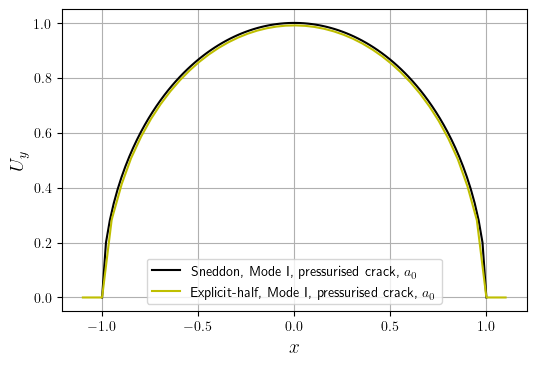

In [5]:
    
plt.xlabel('$x$',fontsize =14)
plt.ylabel(r'$U_y$',fontsize=14)

plt.plot(np.array(x_Sneddon[:])/(0.5*aa), np.array(uy_Sneddon[:])/(2*0.5*aa*(1-nu**2)*p/E), 'k',label='Sneddon, Mode I, pressurised crack, $a_0$')
plt.plot(np.array(x_explicit[:])/(0.5*aa), np.array(uy_explicit[:])/(2*0.5*aa*(1-nu**2)*p/E), 'y',label='Explicit-half, Mode I, pressurised crack, $a_0$')

plt.grid(True)
legend = plt.legend()
plt.savefig('figures/pressureSneddonExplicit.png')  

## Phase field -Sneddon

### Phase field

In [6]:
# phasefield opening
#full domain, top and bottom in y dirction, and left and right in x direction  are  fixed


inputfile_w_pf_full = open('/Users/mollaali/Opening/PhaseField/pressure/full_big/results/Pressureopening.csv','r+')
data_w_pf_full = [row.strip().split('\t') for row in inputfile_w_pf_full]
width_pf_full = []
x_w_pf_full = []

for i in range(len(data_w_pf_full)):
        x_w_pf_full.append(float(data_w_pf_full[i][0]))
        width_pf_full.append(float(data_w_pf_full[i][1]))     
        
        
   
        
inputfile_w_pf_full_keita = open('/Users/mollaali/Opening/PhaseField/pressure/full_keita_quad/results/Pressureopening.csv','r+')
data_w_pf_full_keita = [row.strip().split('\t') for row in inputfile_w_pf_full_keita]
width_pf_full_keita = []
x_w_pf_full_keita = []
for i in range(len(data_w_pf_full_keita)):
        x_w_pf_full_keita.append(float(data_w_pf_full_keita[i][0]))
        width_pf_full_keita.append(float(data_w_pf_full_keita[i][1])) 
        
        


  
        

### Sneddon

In [7]:
E=1.
nu=0.3
p=1.
print(a_eff)
x_Sneddon_eff= np.linspace(-0.5*a_eff,0.5*a_eff,100)
uy_Sneddon_eff=[]
uy_max=2*0.5*a_eff*(1-nu**2)*p/E

for i in range(len(x_Sneddon_eff)):
    uy_Sneddon_eff.append(2*0.5*a_eff*(1-nu**2)*p/E*math.sqrt(1-((x_Sneddon_eff[i])/(0.5*a_eff))**2))

0.22327105669325775


### plot

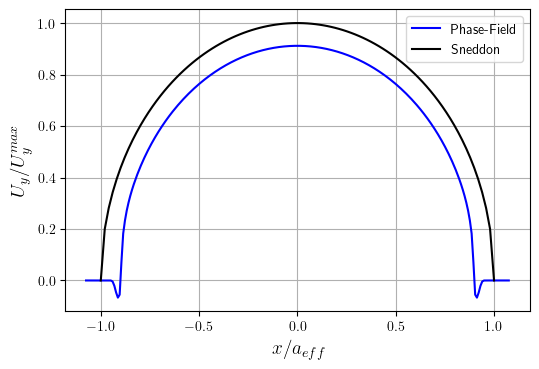

In [8]:
plt.xlabel('$x/a_{eff}$',fontsize =14)
plt.ylabel(r'$U_y/U_y^{max}$',fontsize=14)

plt.plot(np.array(x_w_pf_full[:])/(0.5*a_eff), np.array(width_pf_full[:])/uy_max, 'b',label='Phase-Field')
#plt.plot((1-np.array(x_w_pf_full_keita[:]))/(0.5*a_eff), np.array(width_pf_full_keita[:])/uy_max, 'y',label='Phase-Field, full 2x2  Keita quad $\ell=0.003$')



    

plt.plot(np.array(x_Sneddon_eff[:])/(0.5*a_eff), np.array(uy_Sneddon_eff[:])/uy_max, 'k',label='Sneddon')
plt.grid(True)


legend = plt.legend()
plt.savefig('figures/pressureSneddonPhasefield.png')  


# Center Crack under Shear loading

## Explicit-Sneddon

### Explicit

In [9]:
# fixed x and y at y=0 except for crack 

inputfile_u = open('/Users/mollaali/Opening/explicit/Shear/half/results/shear_half_disp.csv','r')
data_upper_explicit = [row.strip().split(',') for row in inputfile_u]
x_upper_explicit = []
y_upper_explicit = []
ux_upper_explicit =[]
uy_upper_explicit = []
for i in range(len(data_upper_explicit)):
    if i > 0:
        ux_upper_explicit.append(float(data_upper_explicit[i][3]))
        uy_upper_explicit.append(float(data_upper_explicit[i][4]))
        x_upper_explicit.append(float(data_upper_explicit[i][0]))
        y_upper_explicit.append(float(data_upper_explicit[i][1]))
zipped_upper_explicit = sorted(zip(x_upper_explicit,y_upper_explicit,ux_upper_explicit,uy_upper_explicit))


ux_explicit=[]
uy_explicit=[]
x_explicit=[]


for i in range(len(zipped_upper_explicit)):
    ux_explicit.append(zipped_upper_explicit[i][2])
    uy_explicit.append(zipped_upper_explicit[i][3])
    x_explicit.append(zipped_upper_explicit[i][0])


### Sneddon

In [10]:
E=1.
nu=0.3
s=.008
x_Sneddon= np.linspace(-0.5*aa,0.5*aa,100)
ux_Sneddon=[]
for i in range(len(x_Sneddon)):
    ux_Sneddon.append(2*0.5*aa*(1-nu**2)*s/E*math.sqrt(1-((x_Sneddon[i])/(0.5*aa))**2))

### Plot

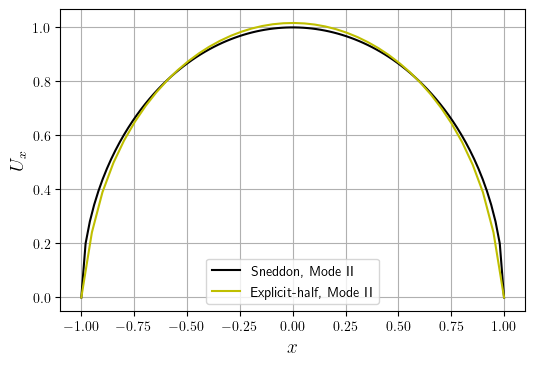

In [11]:
plt.xlabel('$x$',fontsize =14)
plt.ylabel(r'$U_x$',fontsize=14)

plt.plot(np.array(x_Sneddon[:])/(0.5*aa), np.array(ux_Sneddon[:])/(2*0.5*aa*(1-nu**2)*s/E), 'k',label='Sneddon, Mode II')
plt.plot(np.array(x_explicit[:])/(0.5*aa), np.array(ux_explicit[:])/(2*0.5*aa*(1-nu**2)*s/E), 'y',label='Explicit-half, Mode II')

plt.grid(True)
legend = plt.legend()
plt.savefig('figures/shearSneddonExplicit.png')  

## Phase field-Sneddon

In [12]:
inputfile_u = open('/Users/mollaali/Opening/explicit/Shear/full/Fixed_Center/results/upper.csv','r')


data_upper_explicit = [row.strip().split(',') for row in inputfile_u]
x_upper_explicit = []
y_upper_explicit = []
ux_upper_explicit =[]
uy_upper_explicit = []
for i in range(len(data_upper_explicit)):
    if i > 0:
        ux_upper_explicit.append(float(data_upper_explicit[i][0]))
        uy_upper_explicit.append(float(data_upper_explicit[i][1]))
        x_upper_explicit.append(float(data_upper_explicit[i][2]))
        y_upper_explicit.append(float(data_upper_explicit[i][3]))
zipped_upper_explicit = sorted(zip(x_upper_explicit,y_upper_explicit,ux_upper_explicit,uy_upper_explicit))

 
########## 
inputfile_u_l = open('/Users/mollaali/Opening/explicit/Shear/full/Fixed_Center/results/lower.csv','r')
data_lower_explicit = [row.strip().split(',') for row in inputfile_u_l]
x_lower_explicit = []
y_lower_explicit = []
ux_lower_explicit =[]
uy_lower_explicit = []
for i in range(len(data_lower_explicit)):
    if i > 0:
        ux_lower_explicit.append(float(data_lower_explicit[i][0]))
        uy_lower_explicit.append(float(data_lower_explicit[i][1]))
        
        x_lower_explicit.append(float(data_lower_explicit[i][2]))
        y_lower_explicit.append(float(data_lower_explicit[i][3]))
zipped_lower_explicit = sorted(zip(x_lower_explicit,y_lower_explicit,ux_lower_explicit,uy_lower_explicit))


ux_explicit=[]
uy_explicit=[]
x_explicit=[]

print(len(zipped_lower_explicit))
print(len(zipped_upper_explicit))


for i in range(len(zipped_upper_explicit)):
    ux_explicit.append(zipped_upper_explicit[i][2]-zipped_lower_explicit[i][2])
    uy_explicit.append(zipped_upper_explicit[i][3]-zipped_lower_explicit[i][3])
    x_explicit.append(zipped_lower_explicit[i][0])  







41
41


### phase field

In [124]:
# phasefield opening full domain- fix y at two points at center line (left and right)

inputfile_w_pf_Shear = open('/Users/mollaali/Opening/PhaseField/shear/full_center_fixed/iso_fixed_center/results/Shearopening_l0p01.csv','r+')
data_w_pf_Shear = [row.strip().split('\t') for row in inputfile_w_pf_Shear]
width_pf_Shear = []
x_w_pf_Shear = []

for i in range(len(data_w_pf_Shear)):
        x_w_pf_Shear.append(float(data_w_pf_Shear[i][0]))
        width_pf_Shear.append(float(data_w_pf_Shear[i][1]))
        
        
        
inputfile_w_pf_Shear_l0p005 = open('/Users/mollaali/Opening/PhaseField/shear/full_center_fixed/iso_fixed_center/results/Shearopening_l0p005.csv','r+')
data_w_pf_Shear_l0p005 = [row.strip().split('\t') for row in inputfile_w_pf_Shear_l0p005]
width_pf_Shear_l0p005 = []
x_w_pf_Shear_l0p005 = []

for i in range(len(data_w_pf_Shear_l0p005)):
        x_w_pf_Shear_l0p005.append(float(data_w_pf_Shear_l0p005[i][0]))
        width_pf_Shear_l0p005.append(float(data_w_pf_Shear_l0p005[i][1]))  
        

        
inputfile_w_pf_Shear_l0p005_VolDev = open('/Users/mollaali/Opening/PhaseField/shear/full_center_fixed/VolDev/results/Shearopening_l0p005.csv','r+')
data_w_pf_Shear_l0p005_VolDev = [row.strip().split('\t') for row in inputfile_w_pf_Shear_l0p005_VolDev]
width_pf_Shear_l0p005_VolDev = []
x_w_pf_Shear_l0p005_VolDev = []

for i in range(len(data_w_pf_Shear_l0p005_VolDev)):
        x_w_pf_Shear_l0p005_VolDev.append(float(data_w_pf_Shear_l0p005_VolDev[i][0]))
        width_pf_Shear_l0p005_VolDev.append(float(data_w_pf_Shear_l0p005_VolDev[i][1]))          
        
        
inputfile_w_pf_Shear_l0p005_Masonry = open('/Users/mollaali/Opening/PhaseField/shear/full_center_fixed/Masonry/3030930/Shearopening_l0p005.csv','r+')
data_w_pf_Shear_l0p005_Masonry = [row.strip().split('\t') for row in inputfile_w_pf_Shear_l0p005_Masonry]
width_pf_Shear_l0p005_Masonry = []
x_w_pf_Shear_l0p005_Masonry = []

for i in range(len(data_w_pf_Shear_l0p005_Masonry)):
        x_w_pf_Shear_l0p005_Masonry.append(float(data_w_pf_Shear_l0p005_Masonry[i][0]))
        width_pf_Shear_l0p005_Masonry.append(float(data_w_pf_Shear_l0p005_Masonry[i][1])) 
        
        
inputfile_w_pf_Shear_l0p005_Spectral = open('/Users/mollaali/Opening/PhaseField/shear/full_center_fixed/Spectral/3030937/Shearopening_l0p005.csv','r+')
data_w_pf_Shear_l0p005_Spectral = [row.strip().split('\t') for row in inputfile_w_pf_Shear_l0p005_Spectral]
width_pf_Shear_l0p005_Spectral = []
x_w_pf_Shear_l0p005_Spectral = []

for i in range(len(data_w_pf_Shear_l0p005_Spectral)):
        x_w_pf_Shear_l0p005_Spectral.append(float(data_w_pf_Shear_l0p005_Spectral[i][0]))
        width_pf_Shear_l0p005_Spectral.append(float(data_w_pf_Shear_l0p005_Spectral[i][1]))          
        
#######################################        
inputfile_w_pf_Shear_half_l0p01 = open('/Users/mollaali/Opening/PhaseField/shear/half/results/Shearopening_l0p01.csv','r+')
data_w_pf_Shear_half_l0p01 = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_l0p01]
width_pf_Shear_half_l0p01 = []
x_w_pf_Shear_half_l0p01 = []

for i in range(len(data_w_pf_Shear_half_l0p01)):
        x_w_pf_Shear_half_l0p01.append(float(data_w_pf_Shear_half_l0p01[i][0]))
        width_pf_Shear_half_l0p01.append(float(data_w_pf_Shear_half_l0p01[i][1]))    
        

inputfile_w_pf_Shear_half_l0p005 = open('/Users/mollaali/Opening/PhaseField/shear/half/results/Shearopening_l0p005.csv','r+')
data_w_pf_Shear_half_l0p005 = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_l0p005]
width_pf_Shear_half_l0p005 = []
x_w_pf_Shear_half_l0p005 = []

for i in range(len(data_w_pf_Shear_half_l0p005)):
        x_w_pf_Shear_half_l0p005.append(float(data_w_pf_Shear_half_l0p005[i][0]))
        width_pf_Shear_half_l0p005.append(float(data_w_pf_Shear_half_l0p005[i][1]))  
        
        
        
# Mode II opening

inputfile_w_pf_Shear_half_Iso_l0p0025 = open('/Users/mollaali/Opening/PhaseField/shear/half_0p00125/results/Shearopening_l0p0025.csv','r+')
data_w_pf_Shear_half_Iso_l0p0025 = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_Iso_l0p0025]
width_pf_Shear_half_Iso_l0p0025 = []
x_w_pf_Shear_half_Iso_l0p0025 = []

for i in range(len(data_w_pf_Shear_half_Iso_l0p0025)):
        x_w_pf_Shear_half_Iso_l0p0025.append(float(data_w_pf_Shear_half_Iso_l0p0025[i][0]))
        width_pf_Shear_half_Iso_l0p0025.append(float(data_w_pf_Shear_half_Iso_l0p0025[i][1]))    
        
        
        
        
# Mode II opening

inputfile_w_pf_Shear_half_Iso_l0p0025 = open('/Users/mollaali/Opening/PhaseField/shear/half_0p00125/results/Shearopening_l0p0025.csv','r+')
data_w_pf_Shear_half_Iso_l0p0025 = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_Iso_l0p0025]
width_pf_Shear_half_Iso_l0p0025 = []
x_w_pf_Shear_half_Iso_l0p0025 = []

for i in range(len(data_w_pf_Shear_half_Iso_l0p0025)):
        x_w_pf_Shear_half_Iso_l0p0025.append(float(data_w_pf_Shear_half_Iso_l0p0025[i][0]))
        width_pf_Shear_half_Iso_l0p0025.append(float(data_w_pf_Shear_half_Iso_l0p0025[i][1]))   
        
        
        
# Mode II opening

inputfile_w_pf_Shear_half_Iso_l0p00125_linePF = open('/Users/mollaali/Opening/PhaseField/shear/half_0p00125_linePF/results/Shearopening_l0p00125_linePF.csv','r+')
data_w_pf_Shear_half_Iso_l0p00125_linePF = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_Iso_l0p00125_linePF]
width_pf_Shear_half_Iso_l0p00125_linePF = []
x_w_pf_Shear_half_Iso_l0p00125_linePF = []

for i in range(len(data_w_pf_Shear_half_Iso_l0p00125_linePF)):
        x_w_pf_Shear_half_Iso_l0p00125_linePF.append(float(data_w_pf_Shear_half_Iso_l0p00125_linePF[i][0]))
        width_pf_Shear_half_Iso_l0p00125_linePF.append(float(data_w_pf_Shear_half_Iso_l0p00125_linePF[i][1]))  
        
        
inputfile_w_pf_Shear_half_Iso_l0p000625 = open('/Users/mollaali/Opening/PhaseField/shear/half_0p000625/results/Shearopening_l0p000625.csv','r+')
data_w_pf_Shear_half_Iso_l0p000625 = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_Iso_l0p000625]
width_pf_Shear_half_Iso_l0p000625 = []
x_w_pf_Shear_half_Iso_l0p000625 = []

for i in range(len(data_w_pf_Shear_half_Iso_l0p000625)):
        x_w_pf_Shear_half_Iso_l0p000625.append(float(data_w_pf_Shear_half_Iso_l0p000625[i][0]))
        width_pf_Shear_half_Iso_l0p000625.append(float(data_w_pf_Shear_half_Iso_l0p000625[i][1]))    
        
        
inputfile_w_pf_Shear_half_Iso_l0p000625_unfixed1Elem = open('/Users/mollaali/Opening/PhaseField/shear/half_0p000625_unfixxed1Element/results/Shearopening_l0p000625.csv','r+')
data_w_pf_Shear_half_Iso_l0p000625_unfixed1Elem = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_Iso_l0p000625_unfixed1Elem]
width_pf_Shear_half_Iso_l0p000625_unfixed1Elem = []
x_w_pf_Shear_half_Iso_l0p000625_unfixed1Elem = []

for i in range(len(data_w_pf_Shear_half_Iso_l0p000625_unfixed1Elem)):
        x_w_pf_Shear_half_Iso_l0p000625_unfixed1Elem.append(float(data_w_pf_Shear_half_Iso_l0p000625_unfixed1Elem[i][0]))
        width_pf_Shear_half_Iso_l0p000625_unfixed1Elem.append(float(data_w_pf_Shear_half_Iso_l0p000625_unfixed1Elem[i][1]))           

### Sneddon

In [133]:
aa=.1*2 # for explicit-sneddon case
a = .1*2
ell = 0.00125
h = 0.000625
a_eff = a*(1+pi*ell/(4.*a*(3*h/8./ell+1)))
a_eff

0.20082673490883943

In [134]:
E=1.
nu=0.3
s=.005

x_Sneddon_eff_shear= np.linspace(-0.5*a_eff,0.5*a_eff,100)
ux_Sneddon_eff_shear=[]
ux_max=2*0.5*a_eff*(1-nu**2)*s/E
for i in range(len(x_Sneddon_eff_shear)):
    ux_Sneddon_eff_shear.append(2*0.5*a_eff*(1-nu**2)*s/E*math.sqrt(1-((x_Sneddon_eff_shear[i])/(0.5*a_eff))**2))

### phase field

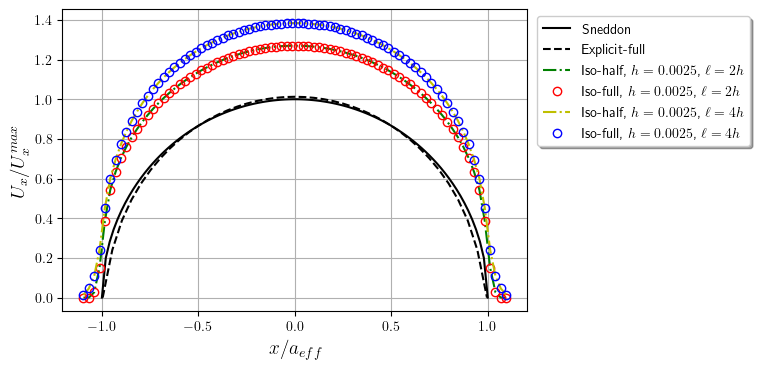

In [135]:
   
plt.xlabel('$x/a_{eff}$',fontsize =14)
plt.ylabel(r'$U_x/U_x^{max}$',fontsize=14)

plt.plot(np.array(x_Sneddon_eff_shear[:])/(0.5*a_eff), np.array(ux_Sneddon_eff_shear[:])/ux_max, 'k',label='Sneddon')
plt.plot(np.array(x_explicit[:])/(0.5*a_eff), 0.5*np.array(ux_explicit[:])/ux_max, '--k',label='Explicit-full')

plt.plot(np.array(x_w_pf_Shear_half_l0p005[:])/(0.5*a_eff), np.array(width_pf_Shear_half_l0p005[:])/ux_max, 'g-.',label='Iso-half, $h=0.0025$, $\ell=2h$')
plt.plot(np.array(x_w_pf_Shear_l0p005[:])/(0.5*a_eff), np.array(width_pf_Shear_l0p005[:])/ux_max, 'ro',fillstyle='none',label='Iso-full, $h=0.0025$, $\ell=2h$')


plt.plot(np.array(x_w_pf_Shear_half_l0p01[:])/(0.5*a_eff), np.array(width_pf_Shear_half_l0p01[:])/ux_max, 'y-.',label='Iso-half, $h=0.0025$, $\ell=4h$')
plt.plot(np.array(x_w_pf_Shear[:])/(0.5*a_eff), np.array(width_pf_Shear[:])/ux_max, 'bo',fillstyle='none',label='Iso-full, $h=0.0025$, $\ell=4h$')








   
plt.grid(True)
legend = plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.),
          fancybox=True, shadow=True, ncol=1)
plt.savefig('figures/shearSneddonPhaseField.png')  

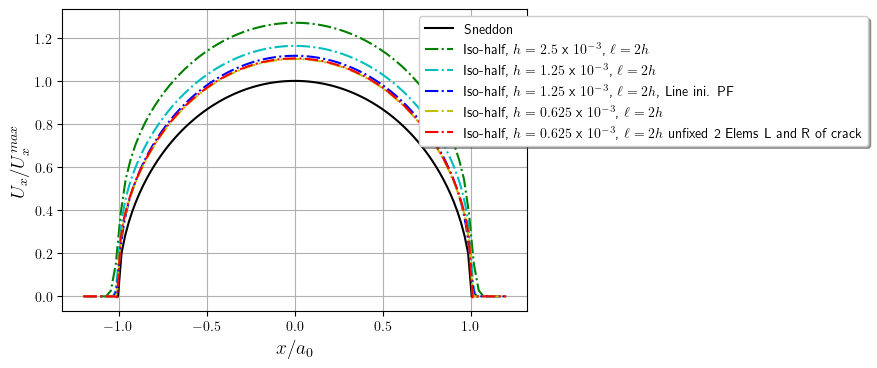

In [136]:
   
plt.xlabel('$x/a_0$',fontsize =14)
plt.ylabel(r'$U_x/U_x^{max}$',fontsize=14)

plt.plot(np.array(x_Sneddon_eff_shear[:])/(0.5*a), np.array(ux_Sneddon_eff_shear[:])/ux_max, 'k',label='Sneddon')

plt.plot(np.array(x_w_pf_Shear_half_l0p005[:])/(0.5*a), np.array(width_pf_Shear_half_l0p005[:])/ux_max, 'g-.',label='Iso-half, $h=2.5$ x $10^{-3}$, $\ell=2h$')
plt.plot(np.array(x_w_pf_Shear_half_Iso_l0p0025[:])/(0.5*a), np.array(width_pf_Shear_half_Iso_l0p0025[:])/ux_max, 'c-.',fillstyle='none',label='Iso-half, $h=1.25$ x $10^{-3}$, $\ell=2h$')
plt.plot(np.array(x_w_pf_Shear_half_Iso_l0p00125_linePF[:])/(0.5*a), np.array(width_pf_Shear_half_Iso_l0p00125_linePF[:])/ux_max, 'b-.',fillstyle='none',label='Iso-half, $h=1.25$ x $10^{-3}$, $\ell=2h$, Line ini. PF ')
plt.plot(np.array(x_w_pf_Shear_half_Iso_l0p000625[:])/(0.5*a), np.array(width_pf_Shear_half_Iso_l0p000625[:])/ux_max, 'y-.',fillstyle='none',label='Iso-half, $h=0.625$ x $10^{-3}$, $\ell=2h$')

plt.plot(np.array(x_w_pf_Shear_half_Iso_l0p000625_unfixed1Elem[:])/(0.5*a), np.array( width_pf_Shear_half_Iso_l0p000625_unfixed1Elem[:])/ux_max, 'r-.',fillstyle='none',label='Iso-half, $h=0.625$ x $10^{-3}$, $\ell=2h$ unfixed 2 Elems L and R of crack ')












   
plt.grid(True)
legend = plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.),
          fancybox=True, shadow=True, ncol=1)
plt.savefig('figures/shearSneddonPhaseField.png')  

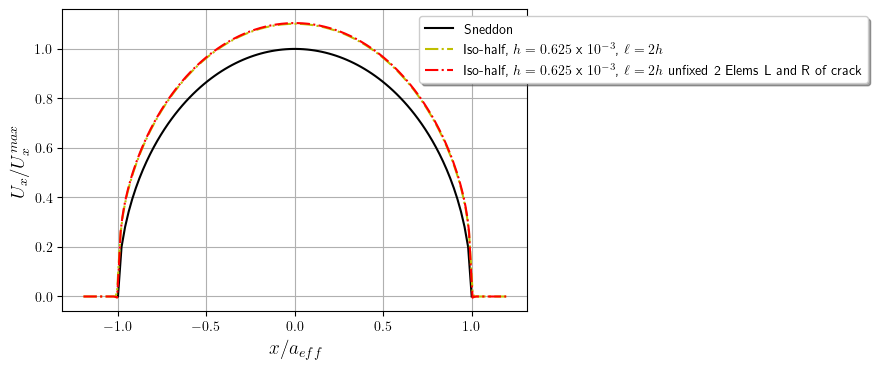

In [138]:
   
plt.xlabel('$x/a_{eff}$',fontsize =14)
plt.ylabel(r'$U_x/U_x^{max}$',fontsize=14)

plt.plot(np.array(x_Sneddon_eff_shear[:])/(0.5*a_eff), np.array(ux_Sneddon_eff_shear[:])/ux_max, 'k',label='Sneddon')


plt.plot(np.array(x_w_pf_Shear_half_Iso_l0p000625[:])/(0.5*a_eff), np.array(width_pf_Shear_half_Iso_l0p000625[:])/ux_max, 'y-.',fillstyle='none',label='Iso-half, $h=0.625$ x $10^{-3}$, $\ell=2h$')
plt.plot(np.array(x_w_pf_Shear_half_Iso_l0p000625_unfixed1Elem[:])/(0.5*a_eff), np.array( width_pf_Shear_half_Iso_l0p000625_unfixed1Elem[:])/ux_max, 'r-.',fillstyle='none',label='Iso-half, $h=0.625$ x $10^{-3}$, $\ell=2h$ unfixed 2 Elems L and R of crack ')


   
plt.grid(True)
legend = plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.),
          fancybox=True, shadow=True, ncol=1)
plt.savefig('figures/shearSneddonPhaseField.png')  

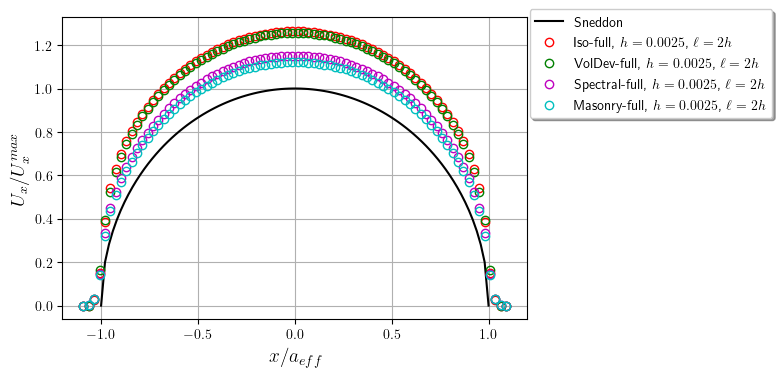

In [64]:
   
plt.xlabel('$x/a_{eff}$',fontsize =14)
plt.ylabel(r'$U_x/U_x^{max}$',fontsize=14)

plt.plot(np.array(x_Sneddon_eff_shear[:])/(0.5*a_eff), np.array(ux_Sneddon_eff_shear[:])/ux_max, 'k',label='Sneddon')


plt.plot(np.array(x_w_pf_Shear_l0p005[:])/(0.5*a_eff), np.array(width_pf_Shear_l0p005[:])/ux_max, 'ro',fillstyle='none',label='Iso-full, $h=0.0025$, $\ell=2h$')

plt.plot(np.array(x_w_pf_Shear_l0p005_VolDev[:])/(0.5*a_eff), np.array(width_pf_Shear_l0p005_VolDev[:])/ux_max,  'go',fillstyle='none',label='VolDev-full, $h=0.0025$, $\ell=2h$')
plt.plot(np.array(x_w_pf_Shear_l0p005_Spectral[:])/(0.5*a_eff), np.array(width_pf_Shear_l0p005_Spectral[:])/ux_max,  'mo',fillstyle='none',label='Spectral-full, $h=0.0025$, $\ell=2h$')
plt.plot(np.array(x_w_pf_Shear_l0p005_Masonry[:])/(0.5*a_eff), np.array(width_pf_Shear_l0p005_Masonry[:])/ux_max, 'co',fillstyle='none',label='Masonry-full, $h=0.0025$, $\ell=2h$')












   
plt.grid(True)
legend = plt.legend( loc='upper left', bbox_to_anchor=(0.99, 1.05),
          fancybox=True, shadow=True, ncol=1)
plt.savefig('figures/shearSneddonPhaseField2.png')  

# Diagonal pulling

## explicit - half

In [103]:
# fixed x and y at y=0 except for crack 
inputfile_u_half = open('/Users/mollaali/Opening/explicit/DiagonalPulling/half_a_eff/results/shear_half_disp_aeff.csv','r')


data_upper_explicit_half  = [row.strip().split(',') for row in inputfile_u_half ]
x_upper_explicit_half  = []
y_upper_explicit_half  = []
ux_upper_explicit_half  =[]
uy_upper_explicit_half  = []

for i in range(len(data_upper_explicit_half )):
    if i > 0:
        ux_upper_explicit_half .append(float(data_upper_explicit_half [i][0]))
        uy_upper_explicit_half .append(float(data_upper_explicit_half [i][1]))
        x_upper_explicit_half .append(float(data_upper_explicit_half [i][2]))
        y_upper_explicit_half .append(float(data_upper_explicit_half [i][3]))
zipped_upper_explicit_half  = sorted(zip(x_upper_explicit_half ,y_upper_explicit_half ,ux_upper_explicit_half ,uy_upper_explicit_half ))


ux_explicit_half =[]
uy_explicit_half =[]
x_explicit_half =[]


for i in range(len(zipped_upper_explicit_half )):
    ux_explicit_half .append(zipped_upper_explicit_half [i][2])
    uy_explicit_half .append(zipped_upper_explicit_half [i][3])
    x_explicit_half .append(zipped_upper_explicit_half [i][0])
    
####################################    
# fixed x and y at y=0 except for crack 
inputfile_u_half_0p000625= open('/Users/mollaali/Opening/explicit/DiagonalPulling/half_a_eff_0p2008/results/shear_half_disp_aeff_0p2008.csv','r')


data_upper_explicit_half_0p000625 = [row.strip().split(',') for row in inputfile_u_half_0p000625]
x_upper_explicit_half_0p000625 = []
y_upper_explicit_half_0p000625 = []
ux_upper_explicit_half_0p000625 =[]
uy_upper_explicit_half_0p000625 = []

for i in range(len(data_upper_explicit_half_0p000625)):
    if i > 0:
        ux_upper_explicit_half_0p000625.append(float(data_upper_explicit_half_0p000625[i][3]))
        uy_upper_explicit_half_0p000625.append(float(data_upper_explicit_half_0p000625[i][4]))
        x_upper_explicit_half_0p000625.append(float(data_upper_explicit_half_0p000625[i][0]))
        y_upper_explicit_half_0p000625.append(float(data_upper_explicit_half_0p000625[i][1]))
zipped_upper_explicit_half_0p000625 = sorted(zip(x_upper_explicit_half_0p000625,y_upper_explicit_half_0p000625,ux_upper_explicit_half_0p000625,uy_upper_explicit_half_0p000625))


ux_explicit_half_0p000625=[]
uy_explicit_half_0p000625=[]
x_explicit_half_0p000625=[]


for i in range(len(zipped_upper_explicit_half_0p000625)):
    ux_explicit_half_0p000625.append(zipped_upper_explicit_half_0p000625[i][2])
    uy_explicit_half_0p000625.append(zipped_upper_explicit_half_0p000625[i][3])
    x_explicit_half_0p000625.append(zipped_upper_explicit_half_0p000625[i][0])





## Phase field - half

In [104]:
# Mode II opening

inputfile_w_pf_Shear_half_l0p005 = open('/Users/mollaali/Opening/PhaseField/DiagonalPulling/half/results/Shearopening_l0p005.csv','r+')
data_w_pf_Shear_half_l0p005 = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_l0p005]
width_pf_Shear_half_l0p005 = []
x_w_pf_Shear_half_l0p005 = []

for i in range(len(data_w_pf_Shear_half_l0p005)):
        x_w_pf_Shear_half_l0p005.append(float(data_w_pf_Shear_half_l0p005[i][0]))
        width_pf_Shear_half_l0p005.append(float(data_w_pf_Shear_half_l0p005[i][1])) 
        

# Mode I opening
inputfile_w_pf_Shear_half_l0p005_y = open('/Users/mollaali/Opening/PhaseField/DiagonalPulling/half/results/Pressureopening.csv','r+')
data_w_pf_Shear_half_l0p005_y = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_l0p005_y]
width_pf_Shear_half_l0p005_y = []
x_w_pf_Shear_half_l0p005_y = []

print(len(data_w_pf_Shear_half_l0p005_y))
for i in range(len(data_w_pf_Shear_half_l0p005_y)):
        x_w_pf_Shear_half_l0p005_y.append(float(data_w_pf_Shear_half_l0p005_y[i][0]))
        width_pf_Shear_half_l0p005_y.append(float(data_w_pf_Shear_half_l0p005_y[i][1]))         
        

        
# Mode II opening
inputfile_w_pf_Diagonal_half_l0p0025_x = open('/Users/mollaali/Opening/PhaseField/DiagonalPulling/half_0p00125/results/Shearopening_l0p0025.csv','r+')
data_w_pf_Diagonal_half_l0p0025_x = [row.strip().split('\t') for row in inputfile_w_pf_Diagonal_half_l0p0025_x]
width_pf_Diagonal_half_l0p0025_x = []
x_w_pf_Diagonal_half_l0p0025_x = []

print(len(data_w_pf_Diagonal_half_l0p0025_x))
for i in range(len(data_w_pf_Diagonal_half_l0p0025_x)):
        x_w_pf_Diagonal_half_l0p0025_x.append(float(data_w_pf_Diagonal_half_l0p0025_x[i][0]))
        width_pf_Diagonal_half_l0p0025_x.append(float(data_w_pf_Diagonal_half_l0p0025_x[i][1])) 
        
        
        
# Mode I opening
inputfile_w_pf_Diagonal_half_l0p0025_y = open('/Users/mollaali/Opening/PhaseField/DiagonalPulling/half_0p00125/results/Pressureopening.csv','r+')
data_w_pf_Diagonal_half_l0p0025_y = [row.strip().split('\t') for row in inputfile_w_pf_Diagonal_half_l0p0025_y]
width_pf_Diagonal_half_l0p0025_y = []
x_w_pf_Diagonal_half_l0p0025_y = []

print(len(data_w_pf_Diagonal_half_l0p0025_y))
for i in range(len(data_w_pf_Diagonal_half_l0p0025_y)):
        x_w_pf_Diagonal_half_l0p0025_y.append(float(data_w_pf_Diagonal_half_l0p0025_y[i][0]))
        width_pf_Diagonal_half_l0p0025_y.append(float(data_w_pf_Diagonal_half_l0p0025_y[i][1]))  
        
        
# Mode II opening
inputfile_w_pf_Diagonal_half_l0p00125_x = open('/Users/mollaali/Opening/PhaseField/DiagonalPulling/half_0p000625/results/Shearopening_l0p000625.csv','r+')
data_w_pf_Diagonal_half_l0p00125_x = [row.strip().split('\t') for row in inputfile_w_pf_Diagonal_half_l0p00125_x]
width_pf_Diagonal_half_l0p00125_x = []
x_w_pf_Diagonal_half_l0p00125_x = []

print(len(data_w_pf_Diagonal_half_l0p00125_x))
for i in range(len(data_w_pf_Diagonal_half_l0p00125_x)):
        x_w_pf_Diagonal_half_l0p00125_x.append(float(data_w_pf_Diagonal_half_l0p00125_x[i][0]))
        width_pf_Diagonal_half_l0p00125_x.append(float(data_w_pf_Diagonal_half_l0p00125_x[i][1])) 
        
        
        
# Mode I opening
inputfile_w_pf_Diagonal_half_l0p00125_y = open('/Users/mollaali/Opening/PhaseField/DiagonalPulling/half_0p000625/results/Pressureopening.csv','r+')
data_w_pf_Diagonal_half_l0p00125_y = [row.strip().split('\t') for row in inputfile_w_pf_Diagonal_half_l0p00125_y]
width_pf_Diagonal_half_l0p00125_y = []
x_w_pf_Diagonal_half_l0p00125_y = []

print(len(data_w_pf_Diagonal_half_l0p00125_y))
for i in range(len(data_w_pf_Diagonal_half_l0p00125_y)):
        x_w_pf_Diagonal_half_l0p00125_y.append(float(data_w_pf_Diagonal_half_l0p00125_y[i][0]))
        width_pf_Diagonal_half_l0p00125_y.append(float(data_w_pf_Diagonal_half_l0p00125_y[i][1]))                  

240
240
240
240
240


In [105]:
# Mode II opening

inputfile_w_pf_Shear_half_Masonry_l0p005 = open('/Users/mollaali/Opening/PhaseField/DiagonalPulling/half_Masonry/results/Shearopening_l0p005.csv','r+')
data_w_pf_Shear_half_Masonry_l0p005 = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_Masonry_l0p005]
width_pf_Shear_half_Masonry_l0p005 = []
x_w_pf_Shear_half_Masonry_l0p005 = []

for i in range(len(data_w_pf_Shear_half_Masonry_l0p005)):
        x_w_pf_Shear_half_Masonry_l0p005.append(float(data_w_pf_Shear_half_Masonry_l0p005[i][0]))
        width_pf_Shear_half_Masonry_l0p005.append(float(data_w_pf_Shear_half_Masonry_l0p005[i][1])) 
        

# Mode I opening
inputfile_w_pf_Shear_half_Masonry_l0p005_y = open('/Users/mollaali/Opening/PhaseField/DiagonalPulling/half_Masonry/results/Pressureopening.csv','r+')
data_w_pf_Shear_half_Masonry_l0p005_y = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_Masonry_l0p005_y]
width_pf_Shear_half_Masonry_l0p005_y = []
x_w_pf_Shear_half_Masonry_l0p005_y = []

print(len(data_w_pf_Shear_half_Masonry_l0p005_y))
for i in range(len(data_w_pf_Shear_half_Masonry_l0p005_y)):
        x_w_pf_Shear_half_Masonry_l0p005_y.append(float(data_w_pf_Shear_half_Masonry_l0p005_y[i][0]))
        width_pf_Shear_half_Masonry_l0p005_y.append(float(data_w_pf_Shear_half_Masonry_l0p005_y[i][1]))         
        
  

240


## Plot

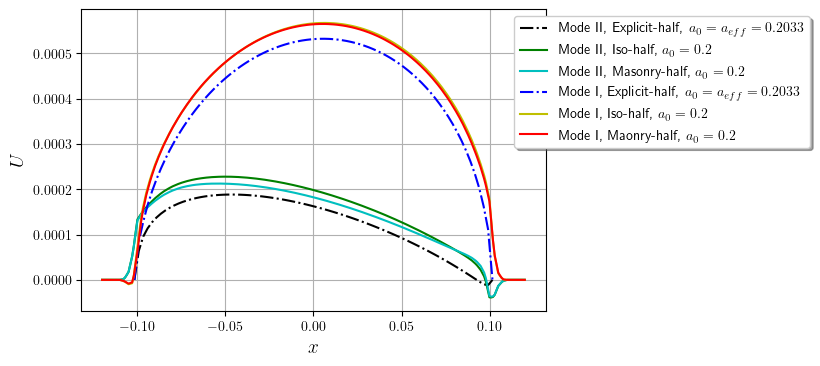

In [106]:
plt.xlabel('$x$',fontsize =14)
plt.ylabel(r'$U$',fontsize=14)

plt.plot(np.array(x_explicit_half[:]), np.array(ux_explicit_half[:]), '-.k',fillstyle='none',label='Mode II, Explicit-half, $a_0=a_{eff}=0.2033$')
plt.plot(np.array(x_w_pf_Shear_half_l0p005[:]), np.array(width_pf_Shear_half_l0p005[:]), 'g-',label='Mode II, Iso-half, $a_0=0.2$')
plt.plot(np.array(x_w_pf_Shear_half_Masonry_l0p005[:]), np.array(width_pf_Shear_half_Masonry_l0p005[:]), 'c-',label='Mode II, Masonry-half, $a_0=0.2$')


#################################
plt.plot(np.array(x_explicit_half[:]), np.array(uy_explicit_half[:]), '-.b',fillstyle='none',label='Mode I, Explicit-half, $a_0=a_{eff}=0.2033$')
plt.plot(np.array(x_w_pf_Shear_half_l0p005_y[:]), np.array(width_pf_Shear_half_l0p005_y[:]), 'y-',label='Mode I, Iso-half, $a_0=0.2$')
plt.plot(np.array(x_w_pf_Shear_half_Masonry_l0p005_y[:]), np.array(width_pf_Shear_half_Masonry_l0p005_y[:]), 'r-',label='Mode I, Maonry-half, $a_0=0.2$')


   
plt.grid(True)
legend = plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.),
          fancybox=True, shadow=True, ncol=1)
plt.savefig('figures/DiagPullModeI_II.png') 

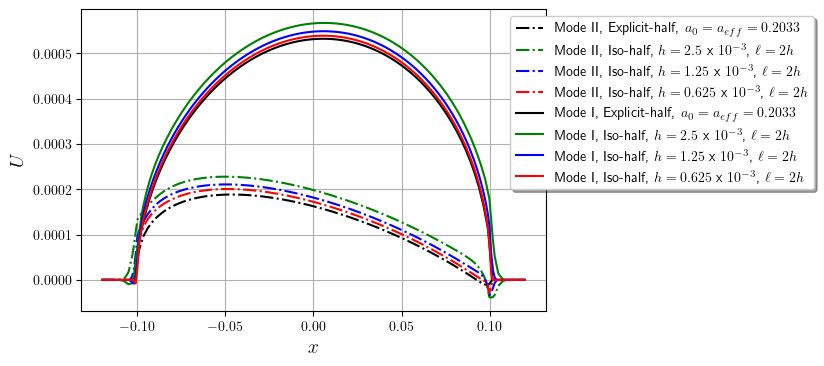

In [107]:
plt.xlabel('$x$',fontsize =14)
plt.ylabel(r'$U$',fontsize=14)

plt.plot(np.array(x_explicit_half[:]), np.array(ux_explicit_half[:]), '-.k',fillstyle='none',label='Mode II, Explicit-half, $a_0=a_{eff}=0.2033$')
plt.plot(np.array(x_w_pf_Shear_half_l0p005[:]), np.array(width_pf_Shear_half_l0p005[:]), 'g-.',label='Mode II, Iso-half, $h=2.5$ x $10^{-3}$, $\ell=2h$')
plt.plot(np.array(x_w_pf_Diagonal_half_l0p0025_x[:]), np.array(width_pf_Diagonal_half_l0p0025_x[:]), 'b-.',label='Mode II, Iso-half, $h=1.25$ x $10^{-3}$, $\ell=2h$')
plt.plot(np.array(x_w_pf_Diagonal_half_l0p00125_x[:]), np.array(width_pf_Diagonal_half_l0p00125_x[:]), 'r-.',label='Mode II, Iso-half, $h=0.625$ x $10^{-3}$, $\ell=2h$')



#################################
plt.plot(np.array(x_explicit_half[:]), np.array(uy_explicit_half[:]), '-k',fillstyle='none',label='Mode I, Explicit-half, $a_0=a_{eff}=0.2033$')
plt.plot(np.array(x_w_pf_Shear_half_l0p005_y[:]), np.array(width_pf_Shear_half_l0p005_y[:]), 'g-',label='Mode I, Iso-half, $h=2.5$ x $10^{-3}$, $\ell=2h$')
plt.plot(np.array(x_w_pf_Diagonal_half_l0p0025_y[:]), np.array(width_pf_Diagonal_half_l0p0025_y[:]), 'b-',label='Mode I, Iso-half, $h=1.25$ x $10^{-3}$, $\ell=2h$')
plt.plot(np.array(x_w_pf_Diagonal_half_l0p00125_y[:]), np.array(width_pf_Diagonal_half_l0p00125_y[:]), 'r-',label='Mode I, Iso-half, $h=0.625$ x $10^{-3}$, $\ell=2h$')




   
plt.grid(True)
legend = plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.),
          fancybox=True, shadow=True, ncol=1)
plt.savefig('figures/DiagPullModeI_II.png') 

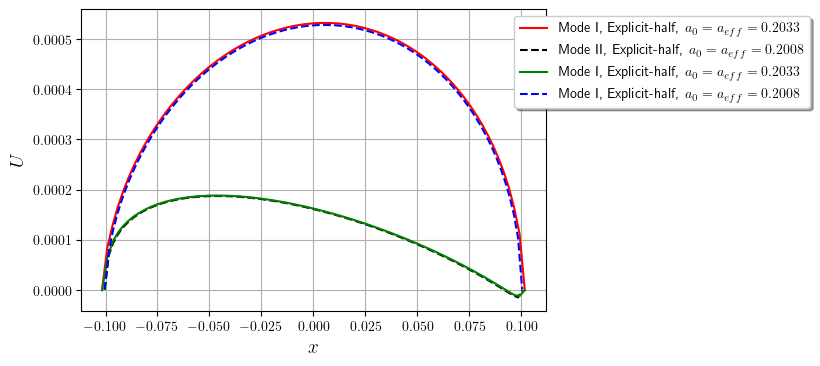

In [122]:
plt.xlabel('$x$',fontsize =14)
plt.ylabel(r'$U$',fontsize=14)

plt.plot(np.array(x_explicit_half[:]), np.array(uy_explicit_half[:]), '-r',fillstyle='none',label='Mode I, Explicit-half, $a_0=a_{eff}=0.2033$')
plt.plot(np.array(x_explicit_half_0p000625[:]), np.array(ux_explicit_half_0p000625[:]), '--k',fillstyle='none',label='Mode II, Explicit-half, $a_0=a_{eff}=0.2008$')




#################################
plt.plot(np.array(x_explicit_half[:]), np.array(ux_explicit_half[:]), '-g',fillstyle='none',label='Mode I, Explicit-half, $a_0=a_{eff}=0.2033$')
plt.plot(np.array(x_explicit_half_0p000625[:]), np.array(uy_explicit_half_0p000625[:]), '--b',fillstyle='none',label='Mode I, Explicit-half, $a_0=a_{eff}=0.2008$')




   
plt.grid(True)
legend = plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.),
          fancybox=True, shadow=True, ncol=1)
plt.savefig('figures/DiagPullModeI_II.png') 

In [88]:
a = .1*2
ell = 0.00125
h = 0.000625
a_eff = a*(1+pi*ell/(4.*a*(3*h/8./ell+1)))
a_eff

0.20082673490883943

# Tensile loading

## explicit full

In [23]:
####################################################################a=a_eff



inputfile_u_tensile = open('/Users/mollaali/Opening/explicit/tensile/full_a_eff_h0p0025/results/upper.csv','r')


data_upper_explicit_tensile = [row.strip().split(',') for row in inputfile_u_tensile]
x_upper_explicit_tensile = []
y_upper_explicit_tensile = []
ux_upper_explicit_tensile =[]
uy_upper_explicit_tensile = []
for i in range(len(data_upper_explicit_tensile)):
    if i > 0:
        ux_upper_explicit_tensile.append(float(data_upper_explicit_tensile[i][0]))
        uy_upper_explicit_tensile.append(float(data_upper_explicit_tensile[i][1]))
        x_upper_explicit_tensile.append(float(data_upper_explicit_tensile[i][2]))
        y_upper_explicit_tensile.append(float(data_upper_explicit_tensile[i][3]))
zipped_upper_explicit_tensile = sorted(zip(x_upper_explicit_tensile,y_upper_explicit_tensile,ux_upper_explicit_tensile,uy_upper_explicit_tensile))



    
    
########## 
inputfile_u_l_tensile = open('/Users/mollaali/Opening/explicit/tensile/full_a_eff_h0p0025/results/lower.csv','r')
data_lower_explicit_tensile = [row.strip().split(',') for row in inputfile_u_l_tensile]
x_lower_explicit_tensile = []
y_lower_explicit_tensile = []
ux_lower_explicit_tensile =[]
uy_lower_explicit_tensile = []
for i in range(len(data_lower_explicit_tensile)):
    if i > 0:
        ux_lower_explicit_tensile.append(float(data_lower_explicit_tensile[i][0]))
        uy_lower_explicit_tensile.append(float(data_lower_explicit_tensile[i][1]))
        
        x_lower_explicit_tensile.append(float(data_lower_explicit_tensile[i][2]))
        y_lower_explicit_tensile.append(float(data_lower_explicit_tensile[i][3]))
zipped_lower_explicit_tensile = sorted(zip(x_lower_explicit_tensile,y_lower_explicit_tensile,ux_lower_explicit_tensile,uy_lower_explicit_tensile))


ux_explicit_tensile=[]
uy_explicit_tensile=[]
x_explicit_tensile=[]

print(len(zipped_lower_explicit_tensile))
print(len(zipped_upper_explicit_tensile))


for i in range(len(zipped_upper_explicit_tensile)):
    ux_explicit_tensile.append(zipped_upper_explicit_tensile[i][2]-zipped_lower_explicit_tensile[i][2])
    uy_explicit_tensile.append(zipped_upper_explicit_tensile[i][3]-zipped_lower_explicit_tensile[i][3])
    x_explicit_tensile.append(zipped_lower_explicit_tensile[i][0])  
    
    
    
    
    
    

82
82


## explicit half

In [24]:
#a=a_eff
inputfile_u_tensile_half = open('/Users/mollaali/Opening/explicit/tensile/half_a_eff_h0p0025/results/upper.csv','r')
data_upper_explicit_tensile_half = [row.strip().split(',') for row in inputfile_u_tensile_half ]
x_upper_explicit_tensile_half  = []
y_upper_explicit_tensile_half  = []
ux_upper_explicit_tensile_half  =[]
uy_upper_explicit_tensile_half = []

for i in range(len(data_upper_explicit_tensile_half )):
    if i > 0:
        ux_upper_explicit_tensile_half .append(float(data_upper_explicit_tensile_half [i][0]))
        uy_upper_explicit_tensile_half .append(float(data_upper_explicit_tensile_half [i][1]))
        x_upper_explicit_tensile_half.append(float(data_upper_explicit_tensile_half[i][2]))
        y_upper_explicit_tensile_half .append(float(data_upper_explicit_tensile_half[i][3]))
zipped_upper_explicit_tensile_half  = sorted(zip(x_upper_explicit_tensile_half ,y_upper_explicit_tensile_half ,ux_upper_explicit_tensile_half ,uy_upper_explicit_tensile_half ))


ux_explicit_tensile_half =[]
uy_explicit_tensile_half =[]
x_explicit_tensile_half=[]


for i in range(len(zipped_upper_explicit_tensile_half )):
    ux_explicit_tensile_half .append(zipped_upper_explicit_tensile_half [i][2])
    uy_explicit_tensile_half .append(zipped_upper_explicit_tensile_half [i][3])
    x_explicit_tensile_half .append(zipped_upper_explicit_tensile_half [i][0])


## Phase field-full

In [25]:
inputfile_w_pf_tensile_full_l0p005 = open('/Users/mollaali/Opening/PhaseField/tensile/full/results/tensileopening_full.csv','r+')
data_w_pf_tensile_full_l0p005 = [row.strip().split('\t') for row in inputfile_w_pf_tensile_full_l0p005]
width_pf_tensile_full_l0p005 = []
x_w_pf_tensile_full_l0p005 = []

print(len(data_w_pf_tensile_full_l0p005))
for i in range(len(data_w_pf_tensile_full_l0p005)):
        x_w_pf_tensile_full_l0p005.append(float(data_w_pf_tensile_full_l0p005[i][0]))
        width_pf_tensile_full_l0p005.append(float(data_w_pf_tensile_full_l0p005[i][1])) 
    

240


## Phase field-half

In [26]:
inputfile_w_pf_tensile_half_l0p005 = open('/Users/mollaali/Opening/PhaseField/tensile/half/results/tensileopening_half.csv','r+')
data_w_pf_tensile_half_l0p005 = [row.strip().split('\t') for row in inputfile_w_pf_tensile_half_l0p005]
width_pf_tensile_half_l0p005 = []
x_w_pf_tensile_half_l0p005 = []

print(len(data_w_pf_tensile_half_l0p005))
for i in range(len(data_w_pf_tensile_half_l0p005)):
        x_w_pf_tensile_half_l0p005.append(float(data_w_pf_tensile_half_l0p005[i][0]))
        width_pf_tensile_half_l0p005.append(float(data_w_pf_tensile_half_l0p005[i][1])) 
        
        
        
inputfile_w_pf_tensile_half_l0p005_h0p00125 = open('/Users/mollaali/Opening/PhaseField/tensile/half_h0p00125/results/tensileopening_half.csv','r+')
data_w_pf_tensile_half_l0p005_h0p00125 = [row.strip().split('\t') for row in inputfile_w_pf_tensile_half_l0p005_h0p00125]
width_pf_tensile_half_l0p005_h0p00125 = []
x_w_pf_tensile_half_l0p005_h0p00125 = []

print(len(data_w_pf_tensile_half_l0p005_h0p00125))
for i in range(len(data_w_pf_tensile_half_l0p005_h0p00125)):
        x_w_pf_tensile_half_l0p005_h0p00125.append(float(data_w_pf_tensile_half_l0p005_h0p00125[i][0]))
        width_pf_tensile_half_l0p005_h0p00125.append(float(data_w_pf_tensile_half_l0p005_h0p00125[i][1]))         

240
240


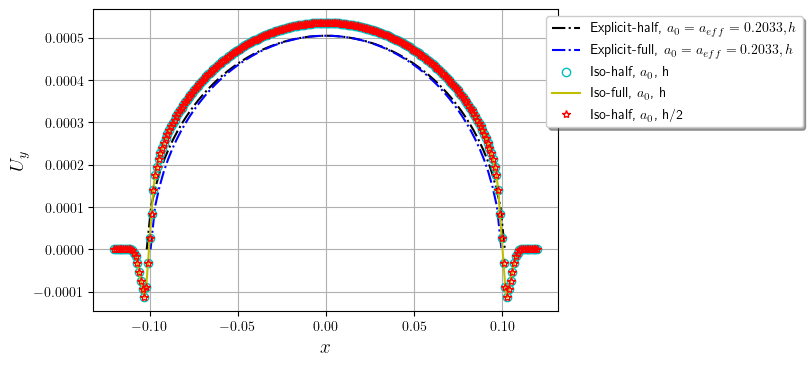

In [27]:

#explicit a=a_eff
plt.plot(np.array(x_explicit_tensile_half[:]), np.array(uy_explicit_tensile_half[:]), '-.k',fillstyle='none',label='Explicit-half, $a_0=a_{eff}=0.2033, h$')
plt.plot(np.array(x_explicit_tensile[:]), 0.5*np.array(uy_explicit_tensile[:]), '-.b',fillstyle='none',label='Explicit-full, $a_0=a_{eff}=0.2033, h$')

#phase field
plt.plot(np.array(x_w_pf_tensile_half_l0p005[:]), np.array(width_pf_tensile_half_l0p005[:]), 'oc',fillstyle='none',label='Iso-half, $a_0$, h')
plt.plot(np.array(x_w_pf_tensile_full_l0p005[:]), np.array(width_pf_tensile_full_l0p005[:]), '-y',fillstyle='none',label='Iso-full, $a_0$, h')
plt.plot(np.array(x_w_pf_tensile_half_l0p005_h0p00125[:]), np.array(width_pf_tensile_half_l0p005_h0p00125[:]), '*r',fillstyle='none',label='Iso-half, $a_0$, h/2')



plt.xlabel('$x$',fontsize =14)
plt.ylabel(r'$U_y$',fontsize=14)
plt.grid(True)
legend = plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.),
          fancybox=True, shadow=True, ncol=1)
plt.savefig('figures/TensileExplicitPhaseField.png')  

# Shear

## l/h=2

In [ ]:
# Mode II opening

inputfile_w_pf_Shear_half_Iso_l0p0025 = open('/Users/mollaali/Opening/PhaseField/DiagonalPulling/half_Iso/results/Shearopening_l0p0025.csv','r+')
data_w_pf_Shear_half_Iso_l0p0025 = [row.strip().split('\t') for row in inputfile_w_pf_Shear_half_Iso_l0p0025]
width_pf_Shear_half_Iso_l0p0025 = []
x_w_pf_Shear_half_Iso_l0p0025 = []

for i in range(len(data_w_pf_Shear_half_Iso_l0p0025)):
        x_w_pf_Shear_half_Iso_l0p0025.append(float(data_w_pf_Shear_half_Iso_l0p0025[i][0]))
        width_pf_Shear_half_Iso_l0p0025.append(float(data_w_pf_Shear_half_Iso_l0p0025[i][1])) 